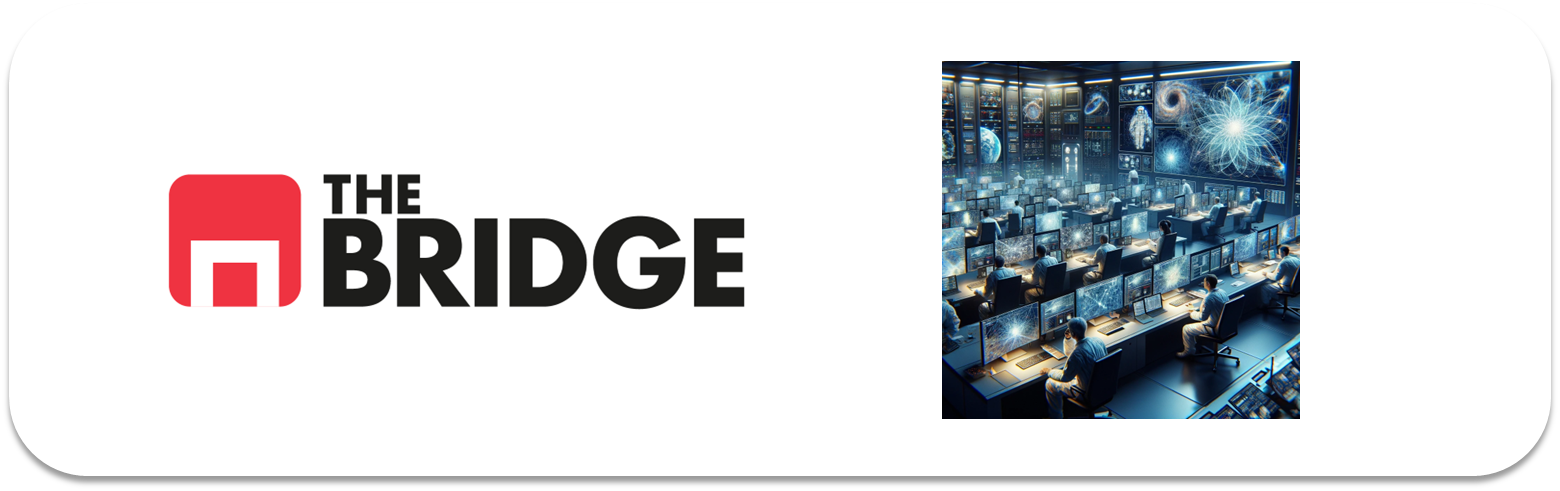

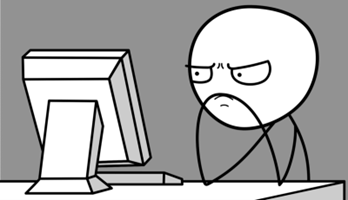

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [25]:
import bootcampviztools as bt
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teniendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [3]:
root_path = "./data/apples/"
train_path = root_path + "Train"
test_path = root_path + "Test"

In [4]:
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = cv2.imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [5]:
X_train, y_train = read_data(train_path)
df = pd.DataFrame({'Image': list(X_train), 'Label': y_train})
df.head()

,Image,Label
0,"[[[255, 255, 254], [255, 255, 255], [255, 255,...",Braeburn
1,"[[[253, 255, 254], [255, 252, 255], [255, 255,...",Braeburn
2,"[[[252, 255, 253], [255, 252, 255], [255, 255,...",Braeburn
3,"[[[253, 255, 255], [255, 253, 255], [255, 255,...",Braeburn
4,"[[[250, 255, 254], [255, 254, 255], [255, 255,...",Braeburn


In [6]:
X_train = read_data(train_path)[0]
y_train = read_data(train_path)[1]
X_test = read_data(test_path)[0]
y_test = read_data(test_path)[1]
X_test_224 = read_data(test_path, reshape_dim=(224,224))

In [7]:
y_train

array(['Braeburn', 'Braeburn', 'Braeburn', ..., 'RedYellow2',
       'RedYellow2', 'RedYellow2'], dtype='<U12')

In [8]:
tipos = pd.Series(y_train).unique().tolist()
tipos


['Braeburn',
 'CrimsonSnow',
 'Golden1',
 'Golden2',
 'Golden3',
 'GrannySmith',
 'PinkLady',
 'Red1',
 'Red2',
 'Red3',
 'RedDelicious',
 'RedYellow1',
 'RedYellow2']

**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

In [9]:
def plot_digits(digits,  labels = [], names=tipos,n_cols = 5,):
    n_rows = ((len(digits) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * 2, n_rows * 2.2))
    if isinstance(digits,pd.DataFrame):
        digits_val = digits.values.reshape(-1,32,32)
    else:
        digits_val = digits
    for index, digit in enumerate(digits_val):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(digit)
        plt.axis("off")
        if len(labels):
            if isinstance(labels, pd.Series):
                plt.title(names[labels.iloc[index]])
            else:
                plt.title(labels[index])

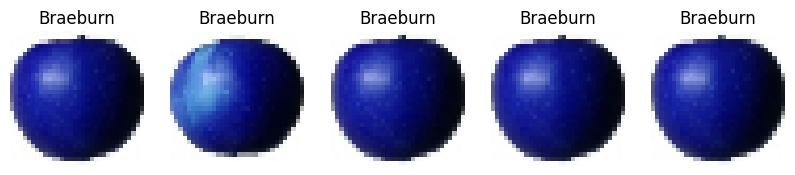

In [10]:
plot_digits(X_train[10:15], y_train[10:15])

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

In [11]:
pd.DataFrame(y_train).value_counts(normalize=True)

0           
RedYellow2      0.104934
Braeburn        0.076827
Golden2         0.076827
GrannySmith     0.076827
Red1            0.076827
Red2            0.076827
RedYellow1      0.076827
RedDelicious    0.076515
Golden3         0.075109
Golden1         0.074953
PinkLady        0.071205
CrimsonSnow     0.069332
Red3            0.066989
Name: proportion, dtype: float64

In [12]:
X_train = X_train/255
X_test = X_test/255

In [13]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# # Crear el codificador
# label_encoder = LabelEncoder()

# # Ajustar el codificador en el conjunto de entrenamiento
# label_encoder.fit(y_train)

# # Transformar ambos conjuntos usando el mismo codificador ajustado
# y_train_le = label_encoder.transform(y_train)
# y_test_le = label_encoder.transform(y_test)

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [14]:
from sklearn.utils import shuffle

X_train_s, y_train_s = shuffle(X_train, y_train)

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [15]:
diccionario = {}
for i in range(len(tipos)):
    diccionario[i] = tipos[i]
diccionario

{0: 'Braeburn',
 1: 'CrimsonSnow',
 2: 'Golden1',
 3: 'Golden2',
 4: 'Golden3',
 5: 'GrannySmith',
 6: 'PinkLady',
 7: 'Red1',
 8: 'Red2',
 9: 'Red3',
 10: 'RedDelicious',
 11: 'RedYellow1',
 12: 'RedYellow2'}

In [16]:
diccionario_2 = {v: k for k, v in diccionario.items()}
diccionario_2


{'Braeburn': 0,
 'CrimsonSnow': 1,
 'Golden1': 2,
 'Golden2': 3,
 'Golden3': 4,
 'GrannySmith': 5,
 'PinkLady': 6,
 'Red1': 7,
 'Red2': 8,
 'Red3': 9,
 'RedDelicious': 10,
 'RedYellow1': 11,
 'RedYellow2': 12}

In [17]:
# Convertir las etiquetas del conjunto de entrenamiento
y_train_le = [diccionario_2[i] for i in y_train]

# Convertir las etiquetas del conjunto de prueba
y_test_le = [diccionario_2[i] for i in y_test]

In [24]:
y_train_le

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


### Ejercicio 6: Zero Shot Learning

Descarga el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [26]:
'''
imagenet es un corpus de imagenes con el que se ha clasificado el ResNet50V2
http://www.image-net.org/

Cargamos toda la red ya entrenada, y la usaremos para predecir
include_top=True --> Para que incluya la fully connected layer.
include_top=False --> Desarrollamos la fully connected layer
ojo el input shape que sea el de las imagenes que introduciremos. Esta limitado a imagenes de tamaño 224x224
classifier_activation se usa si include_top=True
'''

base_model = ResNet50V2(input_shape=(224, 224,3),
                        include_top=True, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción 
                        # en este caso clasificación de imagenes 
                        weights="imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation="softmax")

In [32]:
# Cargar imagenes aleatorias de test:
import os

tipos = []

def read_data(path):
    X = []

    for file in [file for file in os.listdir(path) if file.endswith(".jpg") or file.endswith(".jpeg")]:
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (224, 224))
        print(path + '/' + file)
        tipos.append(file)
        
        X.append(smallimage)

    return np.array(X)

In [70]:
import random

def sample_images_from_subfolders(path, sample_size=10):
    all_images = []
    for subdir, _, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg"):
                all_images.append((subdir, file))
    sampled_images = random.sample(all_images, sample_size)
    return sampled_images

sampled_image_paths = sample_images_from_subfolders(test_path)

# Crear una carpeta para guardar las imágenes seleccionadas
output_folder = './selected_images'
os.makedirs(output_folder, exist_ok=True)

# Guardar las imágenes seleccionadas en la carpeta
for subdir, file in sampled_image_paths:
    image_path = os.path.join(subdir, file)
    image = cv2.imread(image_path)
    subdir_name = os.path.basename(subdir)
    output_path = os.path.join(output_folder, f"{subdir_name}_{file}")
    cv2.imwrite(output_path, image)



In [92]:
sampled_image_paths

[('./data/apples/Test\\Golden1', 'r_60_100.jpg'),
 ('./data/apples/Test\\RedYellow1', '98_100.jpg'),
 ('./data/apples/Test\\PinkLady', '241_100.jpg'),
 ('./data/apples/Test\\RedDelicious', '231_100.jpg'),
 ('./data/apples/Test\\PinkLady', 'r_227_100.jpg'),
 ('./data/apples/Test\\Golden3', 'r_91_100.jpg'),
 ('./data/apples/Test\\RedYellow1', 'r_61_100.jpg'),
 ('./data/apples/Test\\Red1', 'r_81_100.jpg'),
 ('./data/apples/Test\\RedYellow1', '47_100.jpg'),
 ('./data/apples/Test\\GrannySmith', 'r_66_100.jpg')]

In [72]:
# Leer las imágenes seleccionadas para procesarlas
x_figs = read_data('selected_images')

# Procesar las imagenes tal y como entran en el modelo
x_test = preprocess_input(x_figs)
print(x_test.shape)

selected_images/Golden1_r_60_100.jpg
selected_images/Golden3_r_91_100.jpg
selected_images/GrannySmith_r_66_100.jpg
selected_images/PinkLady_241_100.jpg
selected_images/PinkLady_r_227_100.jpg
selected_images/Red1_r_81_100.jpg
selected_images/RedDelicious_231_100.jpg
selected_images/RedYellow1_47_100.jpg
selected_images/RedYellow1_98_100.jpg
selected_images/RedYellow1_r_61_100.jpg
(10, 224, 224, 3)


In [93]:
def plot_image(i, class_predicted, class_prob, true_label, img):
  img = img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  

  plt.imshow(img, cmap=plt.cm.binary)

  plt.xlabel(f"{class_predicted} {class_prob:.2f} ({sampled_image_paths[i]})")

def plot_value_array(predictions_array, predictions_labels):
  #predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(len(predictions_labels)),labels = predictions_labels)
  plt.yticks([])
  thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  plt.xlabel("top-5 predicciones")

  #thisplot[predicted_label].set_color('red')
  #thisplot[true_label].set_color('blue')

In [74]:
num_rows = len(x_test)
num_cols = 1
num_images = num_rows * num_cols

#plt.figure(figsize=(40, 40))

preds = base_model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


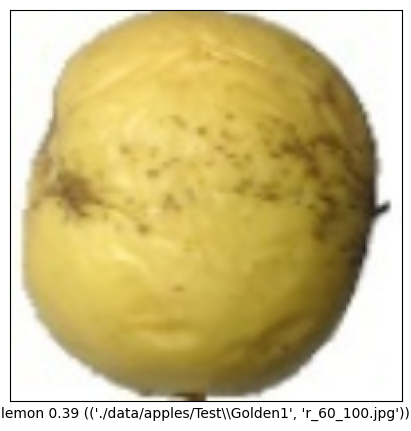

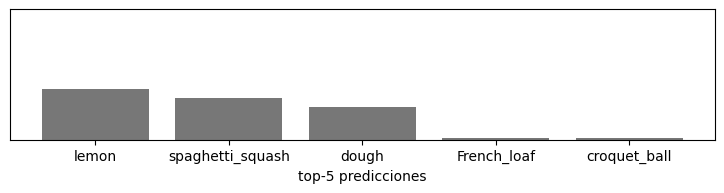

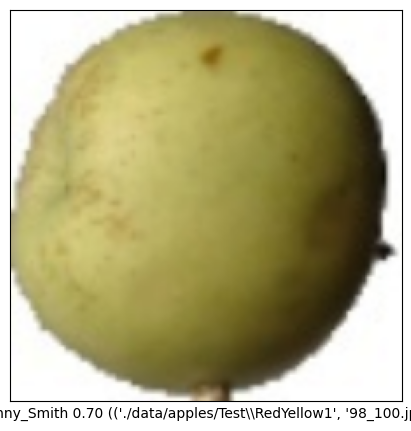

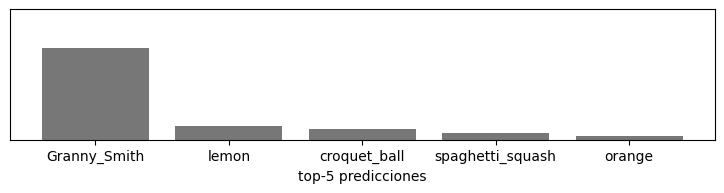

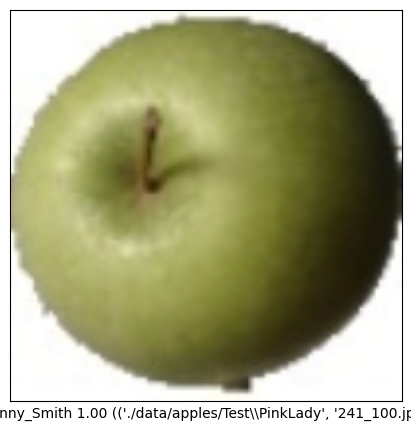

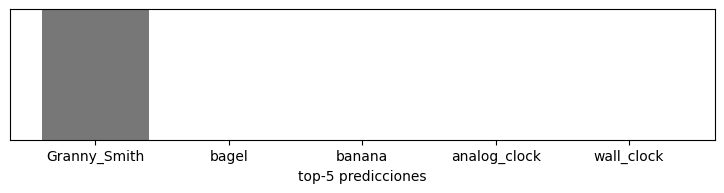

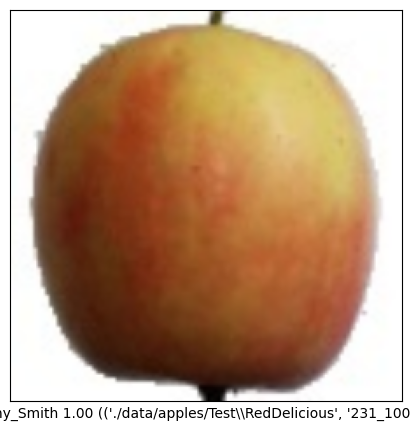

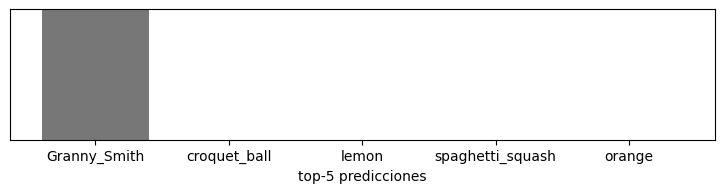

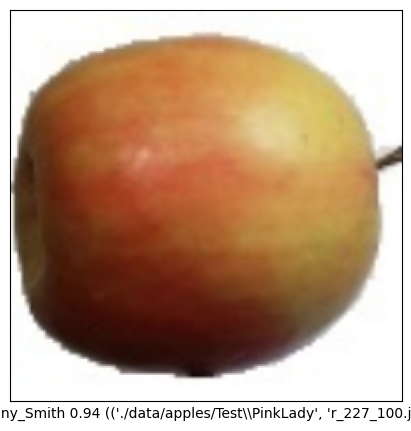

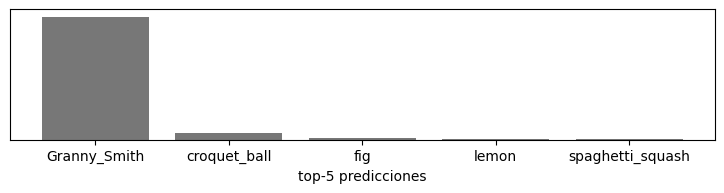

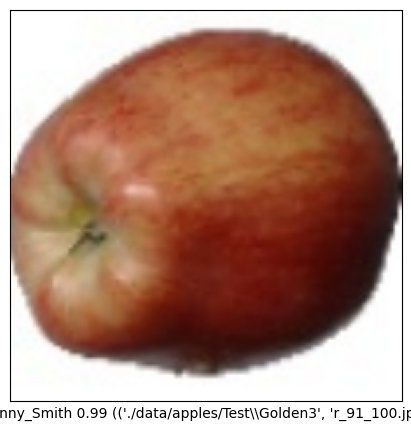

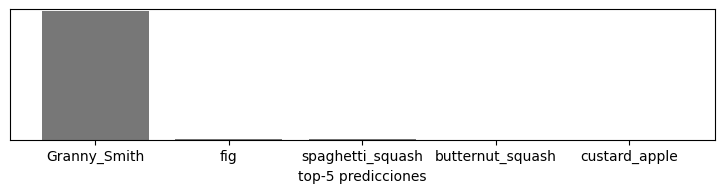

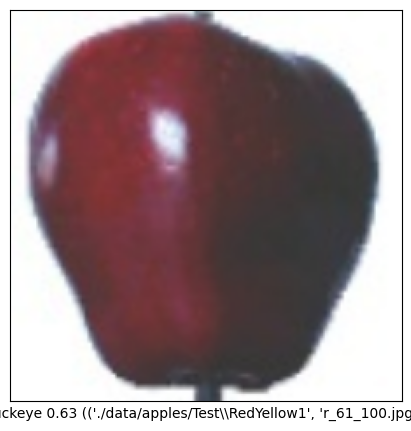

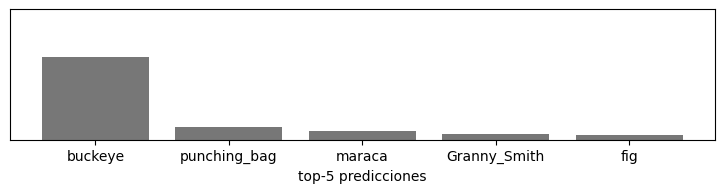

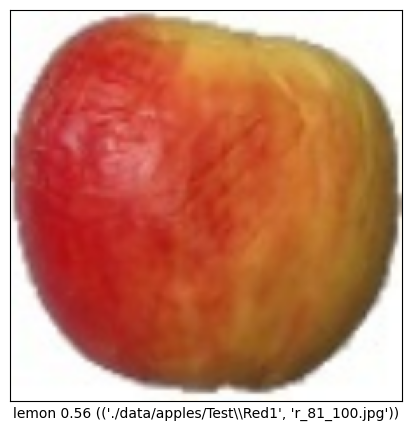

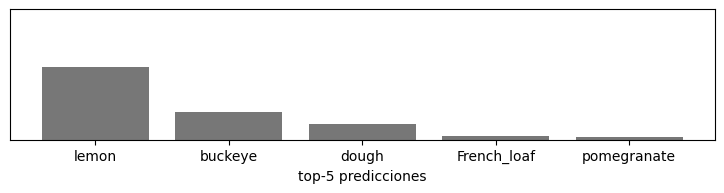

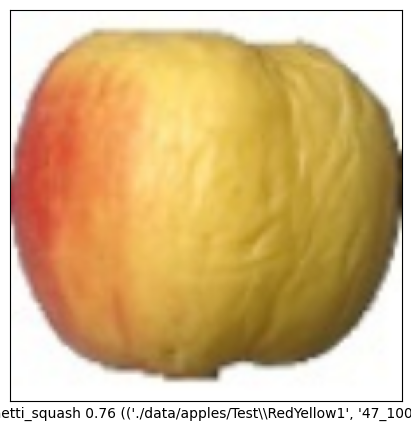

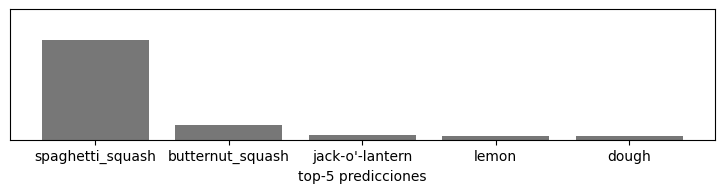

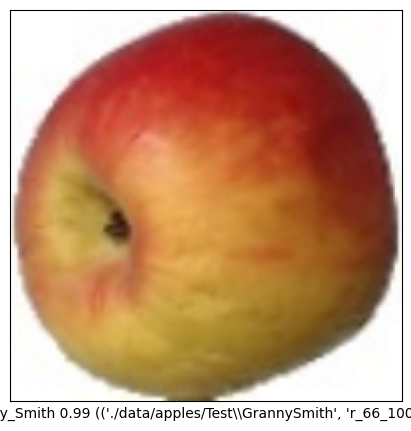

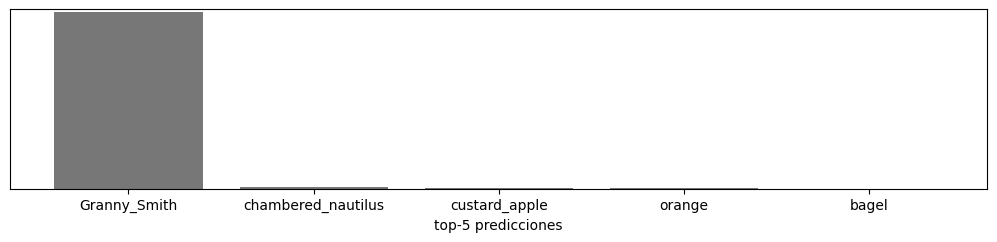

In [95]:
# decode the results into a list of tuples (class, description, probability)
decodes = decode_predictions(preds, top=5)

for i,j in enumerate(decodes):
    prediction_proba = []
    predicted_classes = []
    for decode in j:
        prediction_proba.append(decode[2])
        predicted_classes.append(decode[1])
    plt.figure(figsize=(60, 60))
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i,predicted_classes[0],prediction_proba[0],tipos[i],x_figs)
    plt.figure(figsize=(20, 20))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(prediction_proba, predicted_classes)
plt.tight_layout()
plt.show()

In [ ]:
#Esta claro no sirve porque no incluye nuestra clasificación.

## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [132]:
IM_SIZE=32

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input


base_model = ResNet50V2(input_shape=(IM_SIZE, IM_SIZE,3),
                        include_top=False,  
                        # en este caso clasificación de imagenes 
                        weights="imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation="softmax")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [133]:
for layer in base_model.layers:
    layer.trainable = False

In [134]:
##### FULLY CONNECTED LAYER #####
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(300, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(13, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [135]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [136]:
# Divide los datos de entrenamiento en subconjuntos de entrenamiento y validación
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_s, y_train_le, test_size=0.2, random_state=42)

In [137]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [110]:
X_train_final.shape

(5123, 32, 32, 3)

In [114]:
len(y_train_final)

5123

In [115]:
X_val.shape

(1281, 32, 32, 3)

In [116]:
len(y_val)

1281

In [117]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_final, y_train_final)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

In [138]:
vgghist = model.fit(train_dataset,
                    validation_data = val_dataset,
                    steps_per_epoch = 100, # Cantidad de batches en los que divide el epoch
                    epochs = 10,
                    callbacks=[early_stopping_cb])

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.0812 - loss: 3.2658 - val_accuracy: 0.0788 - val_loss: 2.5660
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.0973 - loss: 2.5866 - val_accuracy: 0.1007 - val_loss: 2.5670
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.0979 - loss: 2.5655 - val_accuracy: 0.1140 - val_loss: 2.5637
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.1004 - loss: 2.5608 - val_accuracy: 0.1062 - val_loss: 2.5655
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.0963 - loss: 2.5588 - val_accuracy: 0.1148 - val_loss: 2.5627
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.1015 - loss: 2.5645 - val_accuracy: 0.1155 - val_loss: 2.5610
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.1032 - loss: 2.5531 - val_accuracy: 0.1124 - val_loss: 2.5594
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.1019 - loss: 2.5586 - val_

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

In [122]:
X_test.shape

(2134, 32, 32, 3)

In [131]:
len(y_test_le)

2134

In [128]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_le)).batch(32)

In [139]:
results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.0045 - loss: 2.5856
test loss, test acc: [2.568459987640381, 0.05763823911547661]


## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [140]:
IM_SIZE=32

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input


base_model_2 = ResNet50V2(input_shape=(IM_SIZE, IM_SIZE,3),
                        include_top=False,  
                        # en este caso clasificación de imagenes 
                        weights= None,
                        classifier_activation="softmax")

In [141]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model_2.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(300, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(13, activation='softmax')(x)

model = tf.keras.models.Model(base_model_2.input, x)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [143]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 24,137,973 (92.08 MB)

 Non-trainable params: 45,440 (177.50 KB)

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

In [145]:
train_dataset_64 = tf.data.Dataset.from_tensor_slices((X_train_final, y_train_final)).batch(64)
val_dataset_64 = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

In [146]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [148]:
vgghist = model.fit(train_dataset_64,
                    validation_data = val_dataset_64,
                    steps_per_epoch = 100, # Cantidad de batches en los que divide el epoch
                    epochs = 60,
                    callbacks=[early_stopping_cb])

Epoch 1/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 384ms/step - accuracy: 0.0989 - loss: 2.5679 - val_accuracy: 0.1085 - val_loss: 2.5635
Epoch 2/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 453ms/step - accuracy: 0.1041 - loss: 2.5655 - val_accuracy: 0.1085 - val_loss: 2.5626
Epoch 3/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 453ms/step - accuracy: 0.1019 - loss: 2.5630 - val_accuracy: 0.1085 - val_loss: 2.5618
Epoch 4/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 419ms/step - accuracy: 0.1023 - loss: 2.5635 - val_accuracy: 0.1085 - val_loss: 2.5612
Epoch 5/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 483ms/step - accuracy: 0.1039 - loss: 2.5615 - val_accuracy: 0.1085 - val_loss: 2.5607
Epoch 6/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 476ms/step - accuracy: 0.1039 - loss: 2.5614 - val_accuracy: 0.1085 - val_loss: 2.5604
Epoch 7/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 532ms/step - accuracy: 0.1039 - loss: 2.5610 - val_accuracy: 0.1085 - val_loss: 2.5601
Epoch 8/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 471ms/step - accuracy: 0.1039 - loss: 2

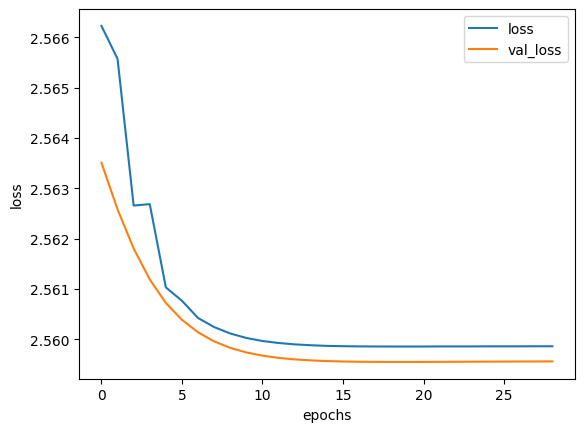

In [149]:
history_df = pd.DataFrame(vgghist.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

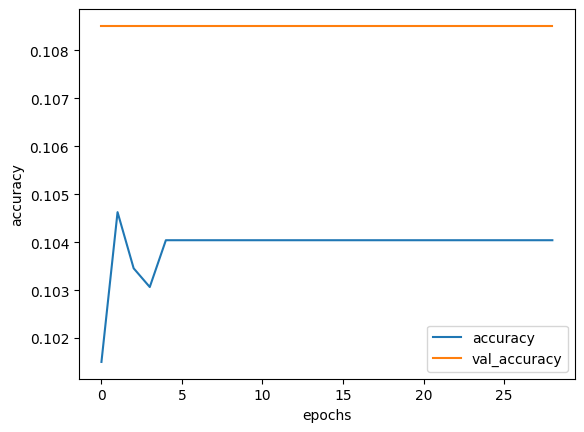

In [150]:
history_df = pd.DataFrame(vgghist.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

In [151]:
test_dataset_64 = tf.data.Dataset.from_tensor_slices((X_test, y_test_le)).batch(64)

In [152]:
results = model.evaluate(test_dataset_64)
print("test loss, test acc:", results)

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.0115 - loss: 2.6027
test loss, test acc: [2.560314416885376, 0.10262417793273926]


In [153]:
y_pred =[np.argmax(prediction) for prediction in model.predict(X_test)]

67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step


In [154]:
print(classification_report(y_test_le, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.00      0.00      0.00       148
           2       0.00      0.00      0.00       160
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00       164
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       166
          11       0.00      0.00      0.00       164
          12       0.10      1.00      0.19       219

    accuracy                           0.10      2134
   macro avg       0.01      0.08      0.01      2134
weighted avg       0.01      0.10      0.02      2134



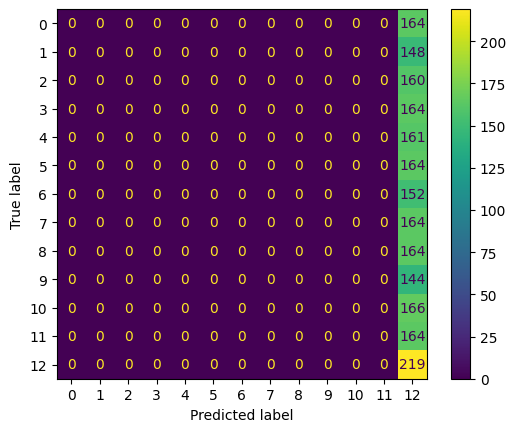

In [155]:
ConfusionMatrixDisplay.from_predictions(y_test_le,y_pred)

In [157]:
y_test_le

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
